# Efficiently loading data to a model

As we noted in the previous tutorial, we'll need more efficient ways for loading data and passing them into models than numpy arrays. In this tutorial we'll look at a few.

In [1]:
!pip install --upgrade tensorflow
import tensorflow as tf
assert tf.__version__[0] == '2', 'this tutorial is for tensorflow versions of 2 or higher'

import pandas as pd
import functools
import time
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

     |████████████████████████████████| 421.8MB 23kB/s 
     |████████████████████████████████| 450kB 39.2MB/s 
     |████████████████████████████████| 3.9MB 52.3MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


## Generators

Let's imagine the following scenario: we have a lot of images stored in our disk and we want to train an image classifier.

In [2]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 3s 0us/step


Suppose we have $N$ photos that belong to $M$ classes. We created a directory for each of the classes and stored that class' photos inside each directory. So we have a directory called `class_1` for the first class that contains $N_1$ images, another directory `class_2` for the second class that contains $N_2$ images, etc. Obviously the sum of all the images in the class directories would be the total number of images in the dataset (i.e. $N_1 + N_2 + ... + N_M = N$ 

Following this scheme, our directory structure would look something like this:

```
data_dir
   |
   |______class_1
   |         |_________img1.jpg
   |         |_________img2.jpg
   |         |
  ...       ...
   |         |_________imgN1.jpg
   |
   |_______class_2
   |         |_________img1.jpg
   |         |_________img2.jpg
  ...       ...
   |         |_________imgN2.jpg
   |
   |_______class_M
             |________img1.jpg
             |________img2.jpg
            ...
             |________imgNM.jpg
```

Our "flower" dataset is already organized like this:

In [3]:
data_dir = Path(flowers)
classes = [p.name for p in data_dir.glob('*') if p.is_dir()]

for c in classes:
  print('--- Class: {:^10} ---'.format('"' + c + '"'))
  for img in list((data_dir / c).glob('*'))[:5]:
    print(img.name)

--- Class:  "tulips"  ---
4588904196_3c5825c7f4.jpg
7094415739_6b29e5215c_m.jpg
13976522214_ccec508fe7.jpg
5633266048_4f4bfb2cf1_n.jpg
13926327692_a07357ff0d.jpg
--- Class:  "roses"   ---
1485142251_ca89254442.jpg
12165480946_c4a3fe182d_n.jpg
6950609394_c53b8c6ac0_m.jpg
16545641666_2781e542a0_m.jpg
7551637034_55ae047756_n.jpg
--- Class:  "daisy"   ---
517054467_d82d323c33_m.jpg
8094774544_35465c1c64.jpg
6148728633_27afc47b0c_m.jpg
525780443_bba812c26a_m.jpg
162362896_99c7d851c8_n.jpg
--- Class: "dandelion" ---
146242691_44d9c9d6ce_n.jpg
15219268336_f2460fca88_m.jpg
17388674711_6dca8a2e8b_n.jpg
18089878729_907ed2c7cd_m.jpg
3451637528_b245144675_n.jpg
--- Class: "sunflowers" ---
6606741847_f0198d83ff.jpg
20171662239_f69b6c12bd_n.jpg
235651658_a7b3e7cbdd.jpg
877083343_e3338c4125.jpg
15191613243_82ee8e0fe8.jpg


Text(0.5, 1.0, 'roses')

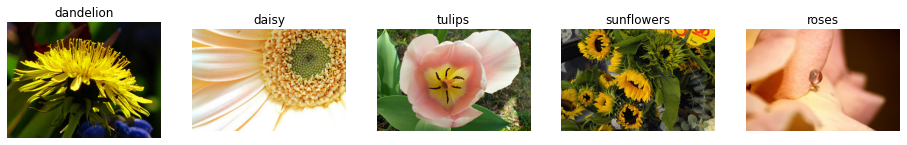

In [4]:
plt.figure(figsize=(16, 5))

ax = plt.subplot(151)
ax.imshow(plt.imread(str(data_dir / 'dandelion' / '2449852402_45d12b9875_n.jpg')))
ax.axis('off')
ax.set_title('dandelion')

ax = plt.subplot(152)
ax.imshow(plt.imread(str(data_dir / 'daisy' / '5673551_01d1ea993e_n.jpg')))
ax.axis('off')
ax.set_title('daisy')

ax = plt.subplot(153)
ax.imshow(plt.imread(str(data_dir / 'tulips' / '14266093711_66d18a1e44_n.jpg')))
ax.axis('off')
ax.set_title('tulips')

ax = plt.subplot(154)
ax.imshow(plt.imread(str(data_dir / 'sunflowers' / '3665455426_9cd1c3af4a_n.jpg')))
ax.axis('off')
ax.set_title('sunflowers')

ax = plt.subplot(155)
ax.imshow(plt.imread(str(data_dir / 'roses' / '14414123198_24606fb32d.jpg')))
ax.axis('off')
ax.set_title('roses')

Back to our task. We want to train a CNN to classify flowers.

Normally we would load the data into a large array, i.e. `x_train` and then create another array `y_train` containing the labels. Then we'd use these two arrays to perform classification.

What if we had too many images that couldn't fit into memory, though. We need a more effective way of passing them to the model. The easiest way to do this is through a **generator**, that at each iteration loads a batch of images from the disk, inputs them to the CNN and then frees that memory to load the next batch.

Let's see how we would do this. First of all we're going to have to generate a list of all images, along with their labels.

In [0]:
images = []
labels = []

for i, c in enumerate(classes):
  im = [str(p) for p in (data_dir / c).glob('*')]
  images += im
  labels += [i] * len(im)

labels = tf.keras.utils.to_categorical(labels, num_classes=len(classes))

Now we'll need a function that will help us load a batch of images.

In [6]:
def load_image_batch(paths, target_size=(256, 256)):
  '''
  Loads images from 'paths', resizes them to 'target_size' and returns them as a 
  numpy array with a shape of (len(paths), target_size[0], target_size[1], channels)
  '''

  return np.stack([np.array(Image.open(p).resize(target_size)) for p in paths])

load_image_batch(images[:10]).shape

(10, 256, 256, 3)

*Note: In the spirit of keras I could use [`tf.keras.preprocessing.image.load_img`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/load_img) and [`tf.keras.preprocessing.image.img_to_array`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/img_to_array) respectively. Since the first uses the [Python Image Library](https://pillow.readthedocs.io/en/stable/) to load the images, I decided to use the same to make a more low-level implementation, which is more pythonic.*

*Note 2: Since this function is loading images from disk, which a very slow operation compared to loading them from memory, I'd expect this function would give a significant boost to the training speed of a Deep Neural Network, if it loaded the images in parallel. Interestingly keras does **not** do this in its [equivalent function](https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/iterator.py#L226).*

We'll wrap this function so that it accepts a list of indices, finds the paths and loads a batch of images and their respective labels.  

In [0]:
def load_batch(indices):
  '''
  Loads a batch of images and labels according to a list of indices.
  '''
  paths = np.array(images)[indices]
  y = np.array(labels)[indices]
  return load_image_batch(paths), y

Finally, we'll need a generator that generates batches of indices from the list and calls the `load_batch` function to prepare a training batch.

*Note: it isn't necessary that we'd use a generator here. This could have just been a class that kept trach of which index we're currently on. I think it's easier, though, through a generator.*

In [0]:
def batch_generator(batch_size=128):
  '''
  Generator that returns batches of samples and their labels.
  '''
  indices = np.random.permutation(len(images))
  ind = 0
  while ind < len(images):
    current_batch_indices = indices[ind:ind+batch_size]
    yield load_batch(current_batch_indices)
    ind += batch_size

gen = batch_generator()

In [9]:
x, y = next(gen)
x.shape, y.shape

((128, 256, 256, 3), (128, 5))

Once our generator runs out of examples, the end of the first epoch has been reached, since the full dataset has been passed through once. 

At this point we would have to re-instantiate the generator. We would also like to reshuffle the training set, a functionality we built into our generator. 

Let's make a dummy training loop to get the idea.

In [10]:
epochs = 3

for e in range(epochs):
  gen = batch_generator()
  i = 0
  for x, y in gen:
    # Here we would train the model on x and y
    if i % 5 == 0:
      print('Epoch {}, Iteration {}'.format(e + 1, i + 1))
    i += 1

Epoch 1, Iteration 1
Epoch 1, Iteration 6
Epoch 1, Iteration 11
Epoch 1, Iteration 16
Epoch 1, Iteration 21
Epoch 1, Iteration 26
Epoch 2, Iteration 1
Epoch 2, Iteration 6
Epoch 2, Iteration 11
Epoch 2, Iteration 16
Epoch 2, Iteration 21
Epoch 2, Iteration 26
Epoch 3, Iteration 1
Epoch 3, Iteration 6
Epoch 3, Iteration 11
Epoch 3, Iteration 16
Epoch 3, Iteration 21
Epoch 3, Iteration 26


The first thing to note is the extremely slow speed and we aren't even training a model! The reason is that each iteration requires $128$ images to be loaded one by one from the disk, a painstakingly slow process. However, with the sizes that image datasets take, having all the data in memory isn't normally an option.

Now we'll actually try to train a model with this generator. To train a keras model on one batch at a time we'll use the `model.train_on_batch()` method. Additionally, we'll time each epoch's training time to evaluate which generator offers the fastest training times.

In [0]:
def create_model(image_shape=(256, 256, 3), num_classes=len(classes)):
  '''
  Function that creates and retuns a compiled CNN.
  '''
  inp = tf.keras.layers.Input(shape=image_shape)
  c1 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(inp)
  c2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(c1)
  p1 = tf.keras.layers.MaxPool2D(strides=2)(c2)
  c3 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(p1)
  c4 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(c3)
  p2 = tf.keras.layers.MaxPool2D(strides=2)(c4)
  c5 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(p2)
  c6 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(c5)
  p3 = tf.keras.layers.MaxPool2D(strides=2)(c6)
  fl = tf.keras.layers.Flatten()(p3)
  out = tf.keras.layers.Dense(num_classes, activation='softmax')(fl)

  model = tf.keras.models.Model(inp, out)

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model


def time_execution(func):
  '''
  Wrapper that times the execution of a function.
  '''

  @functools.wraps(func)
  def wrapper(*args, **kwargs):

    start_time = time.time()
    result = func(*args, **kwargs)
    print('Total execution time: {:.2f}sec'.format(time.time() - start_time))
    return result

  return wrapper

@time_execution
def generator_train(model, generator_factory, num_epochs=5):
  
  for e in range(num_epochs):

    gen = generator_factory()

    start_time = time.time()
    for x, y in gen:

      model.train_on_batch(x, y)

    print('Epoch {}: {:2f}sec'.format(e+1, time.time()-start_time))

In [12]:
model = create_model()
generator_train(model, batch_generator)

Epoch 1: 57.494392sec
Epoch 2: 42.409219sec
Epoch 3: 42.440411sec
Epoch 4: 42.699652sec
Epoch 5: 42.685802sec
Total execution time: 227.73sec


We'll now examine some more options we can use for generating batches of samples.

## Keras' `ImageDataGenerator`

The most popular option when using images is keras' `ImageDataGenerator`. This requires the data to be organized in the same way we have them currently, i.e. **one directory per class**.

This too uses PIL to load the images, so they shouldn't have many differences in terms of performance.

In [13]:
# Instantiate the ImageDataGenerator
ig = tf.keras.preprocessing.image.ImageDataGenerator()

# Create the actual generator, i.e. the DirectoryIterator
gen = ig.flow_from_directory(data_dir, batch_size=128, 
                             target_size=(256, 256), color_mode='rgb')  
# the last two parameters are actually the default, but if we don't want 256x256
# or RGB images, then we'll have to change them manually

Found 3670 images belonging to 5 classes.


These generators aren't much different compared to our own generator. One major difference is that these generators don't raise a `StopIteration` error once they have been exhausted; instead they start again from the beginning. To have the same behavior as before we need to keep track of the iteration and stop once tha model has seen all samples once.

Another minor difference is how to shuffle the data at the end of each epoch. `DirectoryIterator` inherets from `Iterator`, which has a method called [`.on_epoch_end()`](https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/iterator.py#L70), which in turn calls [`._set_index_array()`](https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/iterator.py#L47). We can call any of these two to shuffle the samples in the training set.

We can now modify the training function with the new information in mind.

In [0]:
@time_execution
def keras_generator_train(model, generator, num_epochs=5):
  
  for e in range(num_epochs):

    start_time = time.time()
    i = 0 

    while i < len(images) / 128:
      x, y = next(generator)
      model.train_on_batch(x, y)
      i += 1

    print('Epoch {}: {:2f}sec'.format(e+1, time.time()-start_time))

    gen.on_epoch_end()  # shuffles the dataset

In [15]:
keras_generator_train(model, gen)

Epoch 1: 39.540647sec
Epoch 2: 39.038064sec
Epoch 3: 39.251152sec
Epoch 4: 39.460175sec
Epoch 5: 39.770102sec
Total execution time: 197.06sec


This is quite slower than our own generator and I'm unsure as to why this happens.

Another way to do the same would be:

```python
for i, (x, y) in enumerate(gen):
  model.train_on_batch(x, y)
  if i > len(images) / 128:
    break
```

Note that the concept of an *epoch* is completely arbitrary when using keras generators. We coupld have iterated on `gen` for as long as we liked. We manually track the iteration cound and break off the training loop just to shuffle the samples!

This wasn't the proper way to use an `ImageDataGenerator` to train a keras model. We just did it to compare its time. Keras' `model.fit()` also works with keras generators! Up till recentrly `.fit()` didn't support generators; rather keras offered a counterpart: `model.fit_generator()`. 


In [16]:
model.fit(gen, epochs=5)

  ...
    to  
  ['...']
Train for 29 steps
Epoch 1/5
29/29 [==============================] - 29s 1s/step - loss: 1.0551 - accuracy: 0.5943
Epoch 2/5
29/29 [==============================] - 29s 986ms/step - loss: 0.8723 - accuracy: 0.6850
Epoch 3/5
29/29 [==============================] - 29s 991ms/step - loss: 0.7313 - accuracy: 0.7425
Epoch 4/5
29/29 [==============================] - 29s 998ms/step - loss: 0.6147 - accuracy: 0.7771
Epoch 5/5
29/29 [==============================] - 29s 1s/step - loss: 0.5049 - accuracy: 0.8193


One interesting fact is that it's a lot faster to train a model using `.fit()` rather than `.train_on_batch()`.

## TensorFlow Dataset

TensorFlow on its own part offers its own sort of generator called a `Dataset`. This offers very **high performance** and **flexibility** compared to keras' generators.

Let's build one from scratch. First, wel'll initialize the Dataset from the list of image paths and labels.

In [0]:
ds = tf.data.Dataset.from_tensor_slices((images, labels))

Now, we need a way of loading images from their filepaths. We'll write a function that loads an image from its path. 

Since we initialized our dataset with both the images and the labels, this function will need to accept two arguments (i.e. the image path and its label) and return the loaded image and its label.

In [0]:
def load_image(image_path, label, target_size=(256, 256)):
  '''
  Load an image from a path and resize it.
  '''
  img = tf.io.read_file(image_path)  # read the file
  img = tf.io.decode_jpeg(img)  # decode the bytes in the file as a jpeg image
  img = tf.image.convert_image_dtype(img, tf.float32)  # convert it from [0, 255] to [0, 1]
  img = tf.image.resize(img, target_size)  # resize it to the target size
  return img, label

Now, we need to tell the dataset to *apply* this function to each element. Note that it won't do it now; this will be done on runtime, once each batch is loaded.

In [0]:
ds = ds.map(load_image)

What else do we need? A way to shuffle the dataset, a way to reapeat it once its ended and a way to load batches one at a time.

In [0]:
# Shuffle the dataset
ds = ds.shuffle(buffer_size=1000)

# Repeat it from the beginning once its done
ds = ds.repeat()

# Load the images in batches one at a time
ds = ds.batch(128)

Finally we'll write a similar function as before to train the model with the dataset.

In [0]:
@time_execution
def tf_dataset_train(model, dataset, num_epochs=5):
  
  for e in range(num_epochs):

    gen = iter(dataset)
    start_time = time.time()
    i = 0 

    while i < len(images) / 128:
      x, y = next(gen)
      model.train_on_batch(x, y)
      i += 1

    print('Epoch {}: {:2f}sec'.format(e+1, time.time()-start_time))

In [22]:
tf_dataset_train(model, ds)

Epoch 1: 42.436818sec
Epoch 2: 41.785506sec
Epoch 3: 41.652305sec
Epoch 4: 41.334781sec
Epoch 5: 41.298339sec
Total execution time: 208.72sec


This seems a bit slower than the other two options, however TensorFlow datasets have some optimization tricks. 

The first one involes the ability to cache the preprocessing steps.

In [23]:
def make_dataset(images, labels):
  ds = tf.data.Dataset.from_tensor_slices((images, labels))
  ds = ds.map(load_image)
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.repeat()
  ds = ds.batch(128)
  return ds

ds_cache = make_dataset(images, labels)

tf_dataset_train(model, ds_cache)

Epoch 1: 39.670179sec
Epoch 2: 29.166297sec
Epoch 3: 28.959547sec
Epoch 4: 29.251673sec
Epoch 5: 29.072000sec
Total execution time: 156.16sec


It's surprising that we need to explicitly call cache in this dataset as tensorflow datasets of this size supposedly [auto-caches](https://www.tensorflow.org/datasets/performances#auto-caching) datasets of this size.

This is significantly faster that both other options. For larger datasets, we could cache them to a file:

```python
ds = ds.cache('./dataset.tfcache')
```

Another option we have is to apply the mapping function **in parallel**.

In [24]:
def make_dataset(images, labels):
  ds = tf.data.Dataset.from_tensor_slices((images, labels))
  ds = ds.map(load_image, num_parallel_calls=6)
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.repeat()
  ds = ds.batch(128)
  return ds

ds_parallel = make_dataset(images, labels)

tf_dataset_train(model, ds_cache)

Epoch 1: 29.139337sec
Epoch 2: 29.115611sec
Epoch 3: 28.962578sec
Epoch 4: 29.029684sec
Epoch 5: 29.069684sec
Total execution time: 145.35sec


Even without caching, this provides a significant speedup to the loading time of each batch!

Note that the number of parallel calls can be set as `tf.data.experimental.AUTOTUNE`, which finds the best number according to CPU availability.

One final feature that TensorFlow datasets offer is to **asynchronously** load and preprocess a batch of data on the CPU, while the model is processing training on the previous batch on the GPU.

In [25]:
def make_dataset(images, labels):
  ds = tf.data.Dataset.from_tensor_slices((images, labels))
  ds = ds.map(load_image)
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.repeat()
  ds = ds.batch(128)
  ds = ds.prefetch(buffer_size=1)
  return ds

ds_prefetch = make_dataset(images, labels)

tf_dataset_train(model, ds_prefetch)

Epoch 1: 33.936643sec
Epoch 2: 33.693343sec
Epoch 3: 33.465519sec
Epoch 4: 33.692919sec
Epoch 5: 33.581771sec
Total execution time: 168.53sec


Again, this offers a significant speedup, even without caching or parallel processing. Let's put these three features together and run one final benchmark.

In [0]:
def generator_train(model, generator, gen_type, num_epochs=5):

  epoch_durations = []
  batch_loading_times = []
  model_training_times = []

  start_time = time.time()
  for e in range(num_epochs):

    if gen_type == 'custom':
      gen = generator()
    elif gen_type == 'keras':
      gen = generator
      gen.on_epoch_end()
    else:
      gen = iter(generator)

    epoch_time = time.time()
    i = 0 

    while i < len(images) / 128:
      iter_t1 = time.time()
      x, y = next(gen)
      iter_t2 = time.time()
      model.train_on_batch(x, y)
      iter_t3 = time.time()
      i += 1

      batch_loading_times.append(iter_t2 - iter_t1)
      model_training_times.append(iter_t3 - iter_t2)
    
    epoch_durations.append(time.time() - epoch_time)

  return {'epoch': epoch_durations, 'data load': batch_loading_times,
          'model training': model_training_times,
          'total training': time.time() - start_time}

In [0]:
def make_dataset(images, labels):
  ds = tf.data.Dataset.from_tensor_slices((images, labels))
  ds = ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.repeat()
  ds = ds.batch(128)
  ds = ds.prefetch(buffer_size=1)
  return ds

ds_opt = make_dataset(images, labels)

Run the actual benchmark ($5$ epochs for each generator).

In [55]:
custom_times = generator_train(model, batch_generator, gen_type='custom')
keras_times = generator_train(model, ig.flow_from_directory(data_dir, batch_size=128, 
                                                            target_size=(256, 256), color_mode='rgb'), 
                              gen_type='keras')
tf_times = generator_train(model, ds_opt, gen_type='tensorflow')

Found 3670 images belonging to 5 classes.


Let's plot the results.

In [0]:
def generate_df(results_dict, name='custom'):
  return pd.DataFrame({'batch loading time': results_dict['data load'],
                       'model training time': results_dict['model training'],
                       'total training time': results_dict['total training'],
                       'generator type': name})

dicts = [custom_times, keras_times, tf_times]
names = ['custom', 'keras', 'tensorflow']
df = pd.concat([generate_df(d, n) for d, n in zip(dicts, names)])

First, the most relevant graph: the average time it took to load a batch.

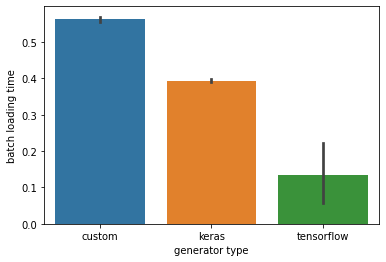

In [58]:
sns.barplot(x='generator type', y='batch loading time', data=df)

Clearly, tensorflow generators are the fastest ones. Now, let's see the time it takes to train a model with each generator. 

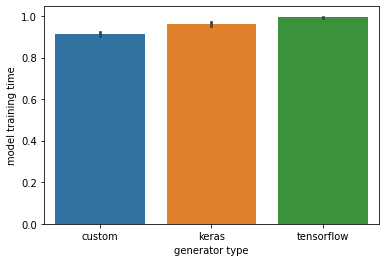

In [59]:
sns.barplot(x='generator type', y='model training time', data=df)

This is a bit surprising, the models shouldn't have had a any differences regarding their generator.

Now, let's check out the average time it took to comple a full epoch.

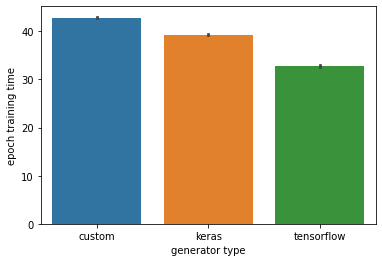

In [62]:
def generate_df_epoch(results_dict, name='custom'):
  return pd.DataFrame({'epoch training time': results_dict['epoch'],
                       'generator type': name})

df_epoch = pd.concat([generate_df_epoch(d, n) for d, n in zip(dicts, names)])

sns.barplot(x='generator type', y='epoch training time', data=df_epoch)

No surprises here. Finally, we'll examine the total training time (i.e. all $5$ epochs).

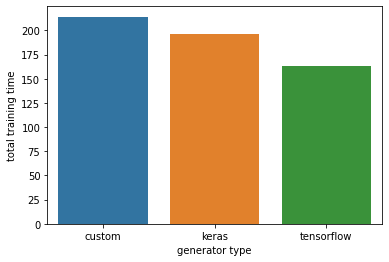

In [63]:
sns.barplot(x='generator type', y='total training time', data=df)

In conclusion, whenever available **use TensorFlow generators**!

We can also use tensorflow generators to train a keras model through its `.fit()` API.

In [91]:
model.fit(ds_opt, steps_per_epoch=len(images)//128, epochs=5)

Train for 28 steps
Epoch 1/5
28/28 [==============================] - 29s 1s/step - loss: 1.6074 - accuracy: 0.2425
Epoch 2/5
28/28 [==============================] - 27s 956ms/step - loss: 1.6048 - accuracy: 0.2433
Epoch 3/5
28/28 [==============================] - 28s 985ms/step - loss: 1.6046 - accuracy: 0.2436
Epoch 4/5
28/28 [==============================] - 27s 976ms/step - loss: 1.6041 - accuracy: 0.2419
Epoch 5/5
28/28 [==============================] - 27s 975ms/step - loss: 1.6038 - accuracy: 0.2464


A last very convenient feature they offer is their ability to be initialized from another generator! TensorFlow refers to this operation as ["consuming a genertor"](https://www.tensorflow.org/guide/data#consuming_python_generators).

In [92]:
# Initialize Dataset from our custom generator
ds = tf.data.Dataset.from_generator(
    batch_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=((128, 256, 256, 3), (128, 5)))

x.shape, y.shape

(TensorShape([128, 256, 256, 3]), TensorShape([128, 5]))

Likewise it can consume a keras generator.

In a future tutorial we'll also see how to incorporate **data augmentation** techniques into these generators.

The next tutorial will delve a bit deeper into TensorFlow and talk about computation graphs and how to train a keras model with a custom training loop.